<a href="https://colab.research.google.com/github/nadianabilaa/TUBES-SA_EXPEDIA-TRAVEL/blob/main/Tugas_Besar_Strategi_Algoritma_Expedia_Travel_Dataset_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nama Kelompok = Expedia Travel Dataset

Kelas = S1IF10-06

Nama Anggota =
1. Ilma Kurnia - 2211102162
2. Nadia Nabila - 2211102174
3. Nida Gina Iswardhani - 2211102306
4. Rahma Ayu Riyantini - 2211102313

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving travel.csv to travel.csv



Results Summary:
------------------------------------------------------------------------------------------------------------------------------------------------------
Size       Branch and Bound Time     Greedy Time     Genetic Algorithm Time    Branch and Bound Cost     Greedy Cost     Genetic Algorithm Cost
------------------------------------------------------------------------------------------------------------------------------------------------------
10         0.019389                  0.000016        3.409032                  9823.84                   9823.84         9823.84        
100        inf                       0.000788        10.027978                 inf                       89469.37        72514.40       
1000       inf                       0.001873        20.986226                 inf                       216504.36       174152.56      
10000      inf                       0.001922        21.704803                 inf                       220485.73       1899

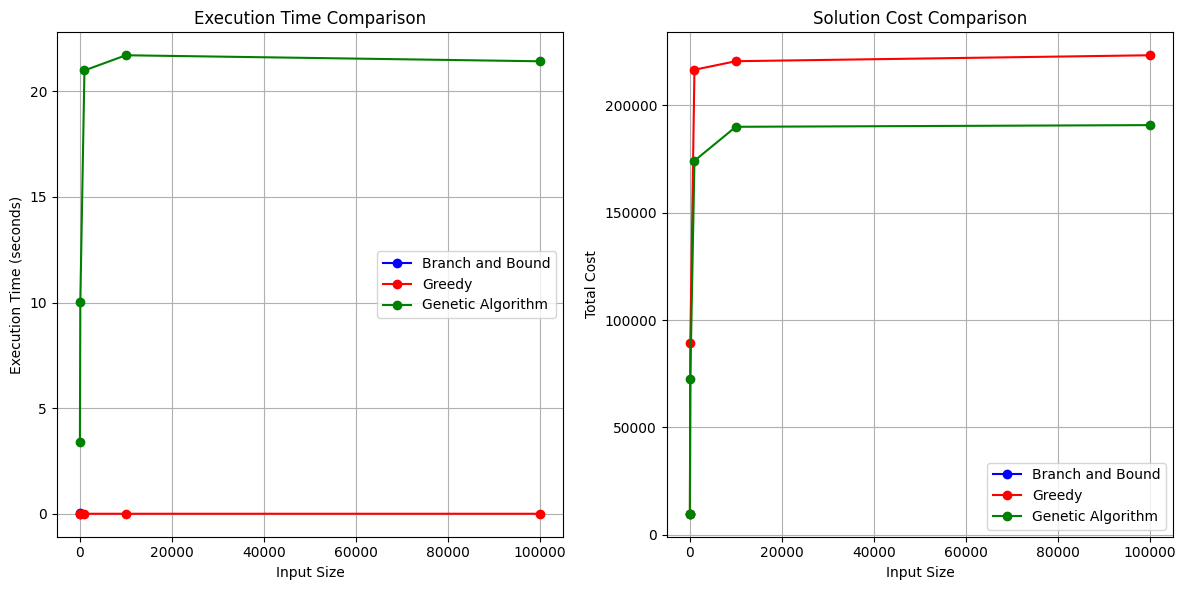

In [ ]:
import pandas as pd
import numpy as np
import time
from typing import List, Tuple, Dict
import logging
import matplotlib.pyplot as plt
from scipy.sparse.csgraph import minimum_spanning_tree

# Mengkonfigurasi logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class ExpediaAnalyzer:
    def __init__(self, file_path: str):
        self.file_path = file_path
        self.df = None
        self.distance_matrix = None
        self.labels = None

    def load_data(self, n_samples: int = None) -> None:
        try:
            self.df = pd.read_csv(self.file_path)
            if n_samples:
                self.df = self.df.sample(n=min(n_samples, len(self.df)), random_state=42)
            self.df = self.df[['hotel_cluster', 'orig_destination_distance']].dropna()
            clusters = sorted(self.df['hotel_cluster'].unique())
            n_clusters = len(clusters)
            self.distance_matrix = np.zeros((n_clusters, n_clusters))
            self.labels = [f"Cluster_{c}" for c in clusters]

            for i, c1 in enumerate(clusters):
                for j, c2 in enumerate(clusters):
                    if i != j:
                        mask = self.df['hotel_cluster'].isin([c1, c2])
                        avg_dist = self.df[mask]['orig_destination_distance'].mean()
                        self.distance_matrix[i][j] = avg_dist if not np.isnan(avg_dist) else 0
            logging.info(f"Loaded data with shape: {self.df.shape}")
        except Exception as e:
            logging.error(f"Error loading data: {str(e)}")
            raise

    def branch_and_bound(self) -> Tuple[List[int], float, float]:
        start_time = time.perf_counter()

        n = len(self.distance_matrix)
        best_cost = float('inf')
        best_path = None

        def mst_bound(path, current_cost):
            """
            Menghitung bound dengan MST untuk perkiraan biaya sisa.
            """
            if len(path) == n:
                return current_cost + self.distance_matrix[path[-1]][path[0]]
            # Menghitung MST pada sisa graf
            remaining = [i for i in range(n) if i not in path]
            sub_matrix = self.distance_matrix[np.ix_(remaining, remaining)]
            mst = minimum_spanning_tree(sub_matrix).toarray()
            mst_cost = mst.sum()
            return current_cost + mst_cost

        def dfs(path, current_cost, visited):
            nonlocal best_cost, best_path
            if len(path) == n:
                total_cost = current_cost + self.distance_matrix[path[-1]][path[0]]
                if total_cost < best_cost:
                    best_cost = total_cost
                    best_path = path[:]
                return

            for i in range(n):
                if i not in visited:
                    visited.add(i)
                    path.append(i)
                    new_cost = current_cost + self.distance_matrix[path[-2]][i] if len(path) > 1 else 0
                    # Pemangkasan dengan bound yang lebih ketat
                    if mst_bound(path, new_cost) < best_cost:
                        dfs(path, new_cost, visited)
                    visited.remove(i)
                    path.pop()

        visited = set([0])  # Start from the first city
        dfs([0], 0, visited)
        execution_time = time.perf_counter() - start_time

        return best_path, best_cost, execution_time

    def greedy(self) -> Tuple[List[int], float, float]:
        start_time = time.perf_counter()
        n = len(self.distance_matrix)
        current = 0
        path = [current]
        unvisited = set(range(1, n))
        total_cost = 0

        while unvisited:
            next_node = min(unvisited, key=lambda x: self.distance_matrix[current][x])
            total_cost += self.distance_matrix[current][next_node]
            current = next_node
            path.append(current)
            unvisited.remove(current)
        total_cost += self.distance_matrix[current][path[0]]
        execution_time = time.perf_counter() - start_time
        return path, total_cost, execution_time

    def genetic_algorithm(self, population_size: int = 100, generations: int = 1000, mutation_rate: float = 0.01) -> Tuple[List[int], float, float]:
        start_time = time.perf_counter()

        n = len(self.distance_matrix)

        # Inisialisasi populasi dengan solusi acak
        population = [np.random.permutation(n).tolist() for _ in range(population_size)]

        def fitness(path):
            # Menghitung biaya dari suatu jalur
            cost = sum(self.distance_matrix[path[i], path[i+1]] for i in range(n - 1))
            cost += self.distance_matrix[path[-1], path[0]]  # Kembali ke titik awal
            return cost

        def crossover(parent1, parent2):
            # Persilangan dua individu (crossover)
            start, end = sorted(np.random.randint(0, n, 2))
            child = [-1] * n
            child[start:end+1] = parent1[start:end+1]
            pointer = 0
            for i in range(n):
                if parent2[i] not in child:
                    while child[pointer] != -1:
                        pointer += 1
                    child[pointer] = parent2[i]
            return child

        def mutate(path):
            # Mutasi jalur
            if np.random.rand() < mutation_rate:
                idx1, idx2 = np.random.randint(0, n, 2)
                path[idx1], path[idx2] = path[idx2], path[idx1]
            return path

        best_cost = float('inf')
        best_path = None

        for generation in range(generations):
            # Evaluasi fitness
            population = sorted(population, key=lambda path: fitness(path))

            # Update solusi terbaik
            if fitness(population[0]) < best_cost:
                best_cost = fitness(population[0])
                best_path = population[0]

            # Seleksi (mengambil dua individu terbaik untuk menjadi orangtua)
            next_generation = population[:2]

            # Crossover dan mutasi
            while len(next_generation) < population_size:
                parent1, parent2 = population[np.random.randint(0, 50)], population[np.random.randint(0, 50)]
                child = crossover(parent1, parent2)
                next_generation.append(mutate(child))

            population = next_generation

        execution_time = time.perf_counter() - start_time

        return best_path, best_cost, execution_time

    def run_comparison(self, sizes: List[int]) -> Dict:
        results = {
            'size': [],
            'branch_and_bound_time': [],
            'branch_and_bound_cost': [],
            'greedy_time': [],
            'greedy_cost': [],
            'genetic_algorithm_time': [],
            'genetic_algorithm_cost': []
        }
        for size in sizes:
            logging.info(f"Processing size: {size}")
            self.load_data(size)

            if size <= 20:
                bb_path, bb_cost, bb_time = self.branch_and_bound()
            else:
                bb_path, bb_cost, bb_time = ["N/A"], float('inf'), float('inf')

            greedy_path, greedy_cost, greedy_time = self.greedy()

            ga_path, ga_cost, ga_time = self.genetic_algorithm()

            results['size'].append(size)
            results['branch_and_bound_time'].append(bb_time)
            results['branch_and_bound_cost'].append(bb_cost)
            results['greedy_time'].append(greedy_time)
            results['greedy_cost'].append(greedy_cost)
            results['genetic_algorithm_time'].append(ga_time)
            results['genetic_algorithm_cost'].append(ga_cost)

        return results

def plot_results(results: Dict):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(results['size'], results['branch_and_bound_time'], 'bo-', label='Branch and Bound')
    plt.plot(results['size'], results['greedy_time'], 'ro-', label='Greedy')
    plt.plot(results['size'], results['genetic_algorithm_time'], 'go-', label='Genetic Algorithm')
    plt.xlabel('Input Size')
    plt.ylabel('Execution Time (seconds)')
    plt.title('Execution Time Comparison')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(results['size'], results['branch_and_bound_cost'], 'bo-', label='Branch and Bound')
    plt.plot(results['size'], results['greedy_cost'], 'ro-', label='Greedy')
    plt.plot(results['size'], results['genetic_algorithm_cost'], 'go-', label='Genetic Algorithm')
    plt.xlabel('Input Size')
    plt.ylabel('Total Cost')
    plt.title('Solution Cost Comparison')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def main():
    file_path = 'travel.csv'
    sizes = [10, 100, 1000, 10000, 100000]
    analyzer = ExpediaAnalyzer(file_path)
    results = analyzer.run_comparison(sizes)

    print("\nResults Summary:")
    print("-" * 150)
    print(f"{'Size':<10} {'Branch and Bound Time':<25} {'Greedy Time':<15} {'Genetic Algorithm Time':<25} {'Branch and Bound Cost':<25} {'Greedy Cost':<15} {'Genetic Algorithm Cost':<15}")
    print("-" * 150)
    for i in range(len(results['size'])):
        print(f"{results['size'][i]:<10} "
              f"{results['branch_and_bound_time'][i]:<25.6f} "
              f"{results['greedy_time'][i]:<15.6f} "
              f"{results['genetic_algorithm_time'][i]:<25.6f} "
              f"{results['branch_and_bound_cost'][i]:<25.2f} "
              f"{results['greedy_cost'][i]:<15.2f} "
              f"{results['genetic_algorithm_cost'][i]:<15.2f}")

    plot_results(results)

if __name__ == "__main__":
    main()



Results Summary:
--------------------------------------------------------------------------------
Size       Dynamic Time         Greedy Time     Dynamic Cost         Greedy Cost    
--------------------------------------------------------------------------------
3          0.000021             0.000010        3026.87              3026.87        
5          0.000029             0.000012        7077.11              7077.11        
7          0.000031             0.000012        7077.11              7077.11        
10         0.000127             0.000018        9823.84              9823.84        
15         0.000609             0.000039        15328.28             15805.58       
20         0.006376             0.000039        24351.87             25251.41       


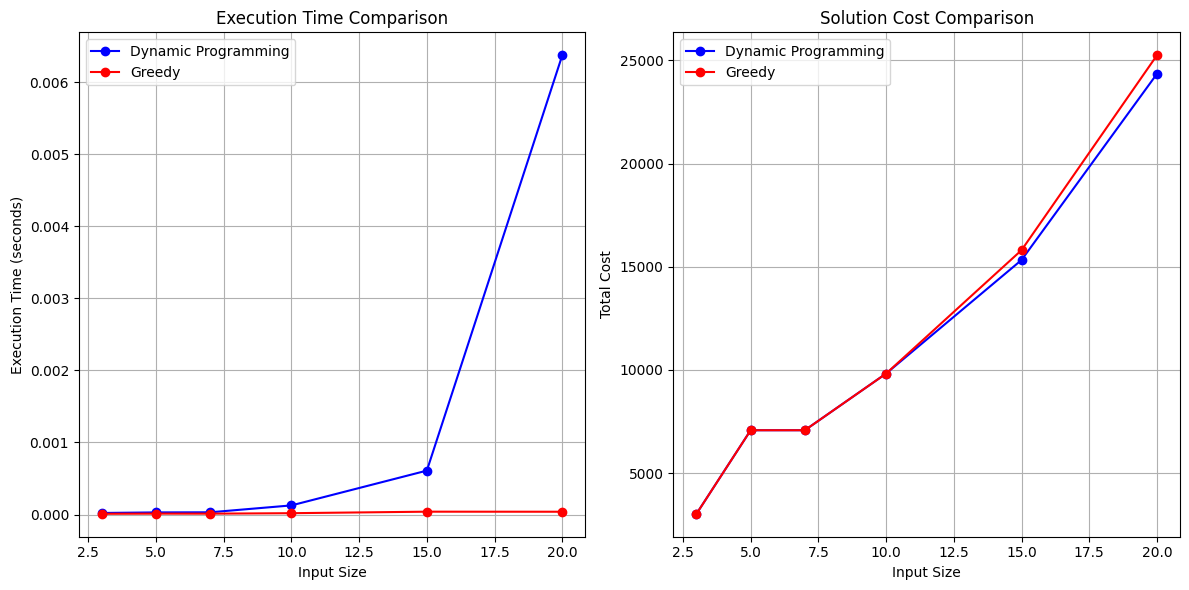

In [ ]:
import pandas as pd
import numpy as np
import itertools
import time
from typing import List, Tuple, Dict
import logging
import matplotlib.pyplot as plt
from datetime import datetime

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class ExpediaAnalyzer:
    def __init__(self, file_path: str):
        """
        Inisialisasi analyzer dengan file dataset Expedia
        """
        self.file_path = file_path
        self.df = None
        self.distance_matrix = None
        self.labels = None

    def load_data(self, n_samples: int = None) -> None:
        """
        Load data dan preprocessing
        """
        try:
            self.df = pd.read_csv(self.file_path)
            if n_samples:
                self.df = self.df.sample(n=min(n_samples, len(self.df)), random_state=42)
            self.df = self.df[['hotel_cluster', 'orig_destination_distance', 'is_booking', 'srch_destination_id']]
            self.df = self.df.dropna()
            clusters = sorted(self.df['hotel_cluster'].unique())
            n_clusters = len(clusters)
            self.distance_matrix = np.zeros((n_clusters, n_clusters))
            self.labels = [f"Cluster_{c}" for c in clusters]
            for i, c1 in enumerate(clusters):
                for j, c2 in enumerate(clusters):
                    if i != j:
                        mask = self.df['hotel_cluster'].isin([c1, c2])
                        avg_dist = self.df[mask]['orig_destination_distance'].mean()
                        self.distance_matrix[i][j] = avg_dist if not np.isnan(avg_dist) else 0
            logging.info(f"Loaded data with shape: {self.df.shape}")
        except Exception as e:
            logging.error(f"Error loading data: {str(e)}")
            raise

    def dynamic_programming(self) -> Tuple[List[int], float, float]:
        """
        Implementasi algoritma Dynamic Programming untuk TSP
        """
        start_time = time.perf_counter()
        n = len(self.distance_matrix)
        all_sets = (1 << n) - 1  # Representasi semua node dalam subset
        dp = [[float('inf')] * n for _ in range(1 << n)]
        parent = [[-1] * n for _ in range(1 << n)]

        def tsp(mask: int, pos: int) -> float:
            if mask == all_sets:
                return self.distance_matrix[pos][0]
            if dp[mask][pos] != float('inf'):
                return dp[mask][pos]

            for city in range(n):
                if mask & (1 << city) == 0:
                    new_cost = self.distance_matrix[pos][city] + tsp(mask | (1 << city), city)
                    if new_cost < dp[mask][pos]:
                        dp[mask][pos] = new_cost
                        parent[mask][pos] = city
            return dp[mask][pos]

        min_cost = tsp(1, 0)

        # Rekonstruksi jalur optimal
        mask = 1
        pos = 0
        path = [0]
        while True:
            pos = parent[mask][pos]
            if pos == -1:
                break
            path.append(pos)
            mask |= (1 << pos)
        path.append(0)  # Kembali ke awal

        execution_time = time.perf_counter() - start_time
        return path, min_cost, execution_time

    def greedy(self) -> Tuple[List[int], float, float]:
        """
        Implementasi algoritma Greedy
        """
        start_time = time.perf_counter()
        n = len(self.distance_matrix)
        current = 0
        path = [current]
        unvisited = set(range(1, n))
        total_cost = 0
        while unvisited:
            next_node = min(unvisited, key=lambda x: self.distance_matrix[current][x])
            total_cost += self.distance_matrix[current][next_node]
            current = next_node
            path.append(current)
            unvisited.remove(current)
        total_cost += self.distance_matrix[current][path[0]]
        execution_time = time.perf_counter() - start_time
        return path, total_cost, execution_time

    def run_comparison(self, sizes: List[int]) -> Dict:
        """
        Jalankan perbandingan untuk berbagai ukuran input
        """
        results = {
            'size': [],
            'dynamic_time': [],
            'dynamic_cost': [],
            'greedy_time': [],
            'greedy_cost': []
        }
        for size in sizes:
            logging.info(f"Processing size: {size}")
            self.load_data(size)
            dp_path, dp_cost, dp_time = self.dynamic_programming()
            greedy_path, greedy_cost, greedy_time = self.greedy()
            results['size'].append(size)
            results['dynamic_time'].append(dp_time)
            results['dynamic_cost'].append(dp_cost)
            results['greedy_time'].append(greedy_time)
            results['greedy_cost'].append(greedy_cost)
        return results

def plot_results(results: Dict):
    """
    Visualisasi hasil perbandingan
    """
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(results['size'], results['dynamic_time'], 'bo-', label='Dynamic Programming')
    plt.plot(results['size'], results['greedy_time'], 'ro-', label='Greedy')
    plt.xlabel('Input Size')
    plt.ylabel('Execution Time (seconds)')
    plt.title('Execution Time Comparison')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(results['size'], results['dynamic_cost'], 'bo-', label='Dynamic Programming')
    plt.plot(results['size'], results['greedy_cost'], 'ro-', label='Greedy')
    plt.xlabel('Input Size')
    plt.ylabel('Total Cost')
    plt.title('Solution Cost Comparison')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def main():
    file_path = 'travel.csv'
    sizes = [3, 5, 7, 10, 15, 20]
    analyzer = ExpediaAnalyzer(file_path)
    results = analyzer.run_comparison(sizes)

    print("\nResults Summary:")
    print("-" * 80)
    print(f"{'Size':<10} {'Dynamic Time':<20} {'Greedy Time':<15} {'Dynamic Cost':<20} {'Greedy Cost':<15}")
    print("-" * 80)
    for i in range(len(results['size'])):
        print(f"{results['size'][i]:<10} "
              f"{results['dynamic_time'][i]:<20.6f} "
              f"{results['greedy_time'][i]:<15.6f} "
              f"{results['dynamic_cost'][i]:<20.2f} "
              f"{results['greedy_cost'][i]:<15.2f}")

    plot_results(results)

if __name__ == "__main__":
    main()
